# Loading Image Data
So far, we have been using datasets which were pre-processed and this will not be the case for real datasets.  
Instead, you will deal with datasets which contain full-sized images which you can get by your smart-phone camera.  
We are going to see how to load images and how to use them to train neural-networks.  
We are going to use a [cat and dogs dataset](https://www.kaggle.com/c/dogs-vs-cats) dataset available by Kaggle.  
  
In the end, we want to train a neural network able to differentiate between cats and dogs.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

The easiest way to load image data is `datasets.ImageFolder` from `torchvision`.  
`dataset = data.ImageFolder("path_to_folder", transform = transform)`  
The `path_to_folder` is a path to the folder where we want download the data and [`transforms`](https://pytorch.org/vision/stable/transforms.html) is the list of preprocessing methods within the module [`torchvision`](https://pytorch.org/vision/stable/index.html).  
  
The `data.ImageFolder` function expects the folders to be organized in a specific way:  
```
root\dog\xxx.png  
root\dog\xxy.png  
root\dog\xxz.png
  
root\cat\xxx.png  
root\cat\xxy.png  
root\cat\xxz.png
```
where each class is a ditectory in the `root` directory. So, when the dataset will be loaded, the images in a specific folder will be labeled as the parent folder.  

## Transforms
When you load the data with `data.ImageFolder` you can perfom some transformations on the loaded dataset. For example, if we have images of different dimension, we need to have them with the same size. So, you can use `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`. We need also to transform the images in PyTorch tensors with `transforms.ToTensor()`.  
Typicallt, you have to compose all these transformations in a pipeline `transforms.Compose()` which accepts a list of transforms and make them in the order as the list order.  
For example:
```
transforms.Compose([transforms.Resize(255), 
                    transforms.CenterCrop(254), 
                    ransforms.ToTensor()])
```

## Data Loaders
With the `ImageFolder` loaded, we have to pass it to a `DataLoader` which takes a dataset with the specific structure we have seen, thus coherent with the `ImageFolder`. It returns batches of images with the respective labels. It is possible to set:  
1. the batch size  
2. if the data after each epoch is shuffled or not
` datatrain = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)`.  
The `dataloader` is a [generator](). So, to get the data out of it you have to:  
1. loop through it  
2. convert it in an iterator and call `naxt()`

```
# we loop through it and we get the batches at each loop (until we haven't passed all the data)
for images, labels in trainloader:
    pass

# get one batch
images, labels = next(iter(trainloader))
```

Now, we load the images of training and we set some transformations on the dataset, finally, we load the dataset.

In [5]:
data_dir = 'Cat_Dog_data/train'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(254),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

<AxesSubplot:>

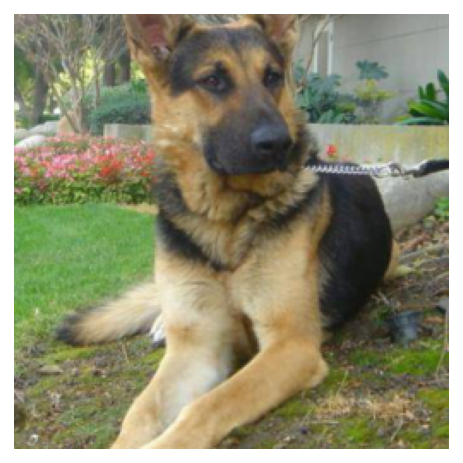

In [13]:
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

## Data Augmentation
A common way to train a neural network is to introduce some randomness in the input data to avoid overfitting.  
So, to make the network generalize. We can randomly:  
1. rotate  
2. mirror  
3. scale  
4. crop  
images during training.  
```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```
Typically, you want to normalize the images. You pass:  
1. a list of means
2. a list of standard deviations  
So the input channels are normalized as:  
`input[channel] = (input[channel]-mean[channel])/std[channel]`  
Normalizing helps keeping the weights near zero, thus it helps to take the training pahse stable (backpropagation). Without the normalization, the training typically fails.  
While we are in the testing phase, we would like to use the unaltered images. So, for validation and testing you will not normalize.  
  
Now, we are going to define the `trainloader` and the `testloader, but for now without doing the normalization for the trainloader.

In [70]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.Resize(50),
                                        transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(51),
                                        transforms.CenterCrop(50),
                                        transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

torch.Size([3, 49, 49])
torch.Size([3, 49, 49])
torch.Size([3, 49, 49])
torch.Size([3, 49, 49])


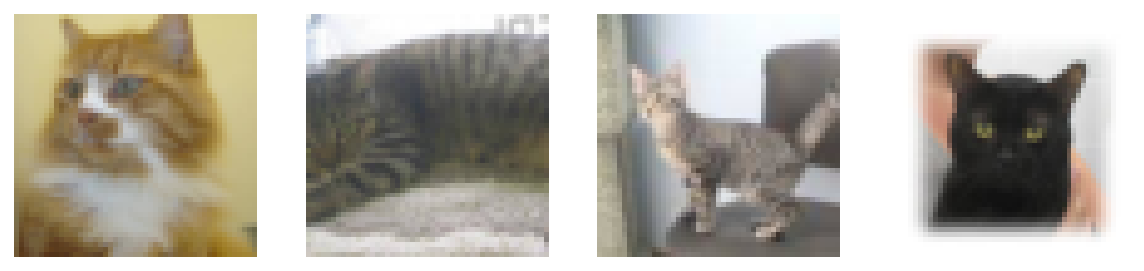

In [63]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)
    print(images[ii].shape)

Now, we have 2 different folders:  
1. train folder  
2. test folder  
So, we can use them in order to classify the images of cats and dogs.  
Now, we train our network.

In [75]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.fc1 = nn.Linear(7500,256)
        self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(32,2)

    def forward(self, x):

        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
     

Now we can do the whole training:  
1. forward pass  
2. backward pass

In [76]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 5
train_losses, test_losses = [], []
for e in range(epochs):
    current_loss = 0.0
    for images, labels in trainloader:
        # when computing the predictions on a new batch
        # we have to throw away the gradients previously computed
        optimizer.zero_grad()
        # images are already flattened thanks to the preparation
        # of the datasets
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        current_loss += loss.item()
        # backward pass
        loss.backward()
        # update the parameters
        optimizer.step()
    else: # we are out of an epoch
        accuracy = 0.0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
            
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                log_ps, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.float))
            

    train_losses.append(current_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}".format(e+1, epochs))
    print("Train Loss: {:.3f}: ".format(current_loss/len(trainloader)))
    print("Test Loss: {:.3f}: ".format(test_loss/len(testloader)))

NameError: name 'testloder' is not defined